<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/006_TensorFlow_Proj_Six_FFNN_EmployeeDoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utils

In [2]:
# utils
import os, sys, pprint
import pandas as pd
import numpy as np
# google
from google.colab import drive
# tensorflow
import tensorflow as tf
from tensorflow import keras
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
# vis
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
print("tensorflow:", tf.__version__)

tensorflow: 2.17.0


## Setting

In [4]:
# setup gpu
if tf.config.list_physical_devices('GPU'):
    physical_devices = tf.config.list_physical_devices("GPU")
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU memory growth set for device:", physical_devices[0])
    except Exception as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

GPU memory growth set for device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
working_dir = '/content/drive/MyDrive/DataSets/employee'
os.chdir(working_dir)
assert os.getcwd() == working_dir

## Funcs

In [7]:
def reduce_memory_usage(df, category = False):
    start_mem = df.memory_usage().sum() / (1024**2)
    print("Memory usage of dataframe is {:2f} MB!".format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            if category:
                df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / (1024**2)
    print("Memory usage after optimization is {:2f} MB!".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem-end_mem) / start_mem))

In [8]:
def display_df(df, message = " "):
    print("Dataframe: {}".format(message))
    num_rows = len(df)
    num_cols = len(df.columns)
    print("num_rows = {:,} \nnum_cols = {:,}".format(num_rows, num_cols))
    display(df.head())
    print("Info:")
    print(df.info())
    df_null = df.isnull().sum()
    if len(df_null)==0:
        print("Number of null data points:",df_null[df_null!=0])
    else:
        print("Number of null data points:")
        print(df_null[df_null!=0])

In [9]:
def summarize_columns(df):
    num_rows = len(df)
    summary = pd.DataFrame(df.dtypes, columns=["dtypes"])
    summary = summary.reset_index()
    summary["col_name"] = summary["index"]
    summary = summary[["col_name", "dtypes"]]
    summary["missing"] = df.isnull().sum().values
    summary["missing_percent"] = summary["missing"].apply(lambda x: round(x*1000/num_rows, 1))
    summary["uniques"] = df.nunique().values
    summary["first_value"] = df.iloc[0].values
    summary["second_value"] = df.iloc[1].values
    summary["third_value"] = df.iloc[2].values
    return summary

## Dataset

In [10]:
dataset = pd.read_csv("employee.csv")

In [11]:
display_df(dataset, message = "dataset")

Dataframe: dataset
num_rows = 14,999 
num_cols = 10


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   department             14999 non-null  object 
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None
Number of null data points:
Series([], dtype: int64)


In [12]:
reduce_memory_usage(dataset, category = True)

Memory usage of dataframe is 1.144455 MB!
Memory usage after optimization is 0.186564 MB!
Decreased by 83.7%


In [13]:
categorical_columns = ['Work_accident','promotion_last_5years', 'department', 'salary']
dataset[categorical_columns] = dataset[categorical_columns].astype('category')

In [14]:
summarize_columns(dataset)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,satisfaction_level,float16,0,0.0,92,0.379883,0.799805,0.109985
1,last_evaluation,float16,0,0.0,65,0.529785,0.859863,0.879883
2,number_project,int8,0,0.0,6,2,5,7
3,average_montly_hours,int16,0,0.0,215,157,262,272
4,time_spend_company,int8,0,0.0,8,3,6,4
5,Work_accident,category,0,0.0,2,0,0,0
6,promotion_last_5years,category,0,0.0,2,0,0,0
7,department,category,0,0.0,10,sales,sales,sales
8,salary,category,0,0.0,3,low,medium,medium
9,left,int8,0,0.0,2,1,1,1


In [15]:
dataset['left'].value_counts()/len(dataset)

,count
left,
0,0.761917
1,0.238083


In [16]:
df = pd.get_dummies(dataset, drop_first=True)

In [17]:
display_df(df, message = "df")

Dataframe: df
num_rows = 14,999 
num_cols = 19


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,left,Work_accident_1,promotion_last_5years_1,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.379883,0.529785,2,157,3,1,False,False,False,False,False,False,False,False,True,False,False,True,False
1,0.799805,0.859863,5,262,6,1,False,False,False,False,False,False,False,False,True,False,False,False,True
2,0.109985,0.879883,7,272,4,1,False,False,False,False,False,False,False,False,True,False,False,False,True
3,0.720215,0.870117,5,223,5,1,False,False,False,False,False,False,False,False,True,False,False,True,False
4,0.370117,0.520020,2,159,3,1,False,False,False,False,False,False,False,False,True,False,False,True,False


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   satisfaction_level       14999 non-null  float16
 1   last_evaluation          14999 non-null  float16
 2   number_project           14999 non-null  int8   
 3   average_montly_hours     14999 non-null  int16  
 4   time_spend_company       14999 non-null  int8   
 5   left                     14999 non-null  int8   
 6   Work_accident_1          14999 non-null  bool   
 7   promotion_last_5years_1  14999 non-null  bool   
 8   department_RandD         14999 non-null  bool   
 9   department_accounting    14999 non-null  bool   
 10  department_hr            14999 non-null  bool   
 11  department_management    14999 non-null  bool   
 12  department_marketing     14999 non-null  bool   
 13  department_product_mng   14999 non-null  bool   
 14  department_sales

In [18]:
df.rename(columns=
          {
              "Work_accident_1": "work_accident",
              "promotion_last_5years_1": "promotion_last_five_years",
              "department_RandD": "department_r_and_d"
          },
          inplace=True)

In [19]:
X = df.drop("left", axis=1, inplace=False).values
y = df["left"].values
print(X.shape, y.shape)

(14999, 18) (14999,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=500, shuffle=True, stratify=y)

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Sequential Model - Shallow

In [22]:
keras.backend.clear_session()
init_model = keras.Sequential(
    layers = [
      keras.layers.Input(shape=(X_train.shape[1],), name= "input_layer"),
      keras.layers.Dense(units=20, activation="relu", name= "dense_layer_one"),
      keras.layers.Dense(units=10, activation="relu", name= "dense_layer_two"),
      keras.layers.Dense(units=1, activation="sigmoid", name= "output_layer")
      ],
    name="init_model"
)
init_model.build(input_shape=(None, X_train.shape[1]))
init_model.summary()

Model: "init_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_layer_one (Dense)              │ (None, 20)                  │             380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_two (Dense)              │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 601 (2.35 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
init_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [24]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = init_model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=10, batch_size=128, callbacks=[callback])

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7162 - loss: 0.6127 - val_accuracy: 0.7600 - val_loss: 0.5028
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7912 - loss: 0.4558 - val_accuracy: 0.7987 - val_loss: 0.4129
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8307 - loss: 0.3705 - val_accuracy: 0.8537 - val_loss: 0.3431
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8780 - loss: 0.3098 - val_accuracy: 0.8833 - val_loss: 0.2899
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9027 - loss: 0.2619 - val_accuracy: 0.9071 - val_loss: 0.2517
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9184 - loss: 0.2287 - val_accuracy: 0.9242 - val_loss: 0.2247
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9297 - loss: 0.2046 - val_accuracy: 0.9325 - val_loss: 0.2077
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9359 - loss: 0.1904 - val_accuracy: 0.9388 - val_loss

In [25]:
init_model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9303 - loss: 0.2076


[0.18830643594264984, 0.9380000233650208]

In [26]:
model_preformance = pd.DataFrame(history.history)
model_preformance.tail()

,accuracy,loss,val_accuracy,val_loss
5,0.924367,0.218135,0.924167,0.224733
6,0.932597,0.197002,0.932500,0.207670
7,0.939473,0.183471,0.938750,0.196393
8,0.942181,0.174373,0.944167,0.190192
9,0.945098,0.167899,0.947083,0.185144


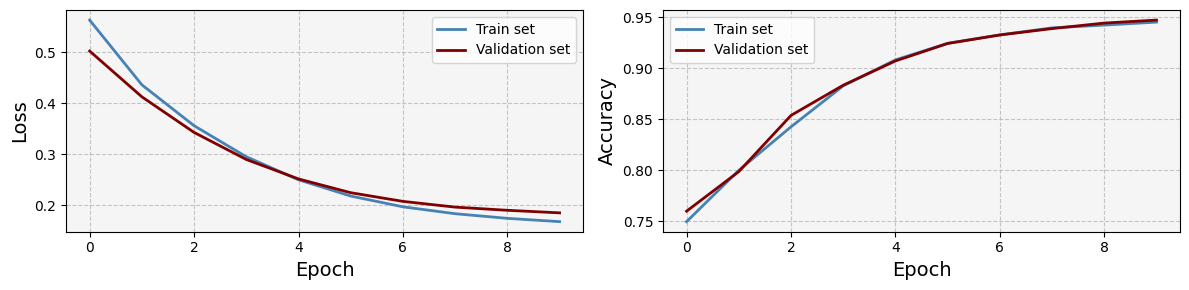

In [29]:
plt.figure(figsize=(12, 3))
ax_one = plt.subplot(1, 2, 1)
plt.plot(model_preformance["loss"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(model_preformance["val_loss"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
ax_one.set_facecolor('#f5f5f5')
plt.tight_layout()
ax_two = plt.subplot(1, 2, 2)
plt.plot(model_preformance["accuracy"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(model_preformance["val_accuracy"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
ax_two.set_facecolor('#f5f5f5')
plt.tight_layout()

## Sequential Model - Deep

In [42]:
keras.backend.clear_session()
seq_model = keras.Sequential(name="seq_model")
seq_model.add(keras.layers.Input(shape=(X_train.shape[1],)))
seq_model.add(keras.layers.Dense(units=10, activation="relu", name="first_layer"))
seq_model.add(keras.layers.Dense(units=30, activation="relu", name="second_layer"))
seq_model.add(keras.layers.Dense(units=20, activation="relu", name="third_layer"))
seq_model.add(keras.layers.Dense(units=1, activation="sigmoid", name="output_layer"))
seq_model.build(input_shape=(None, X_train.shape[1]))
seq_model.summary()

Model: "seq_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ first_layer (Dense)                  │ (None, 10)                  │             190 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (Dense)                 │ (None, 30)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_layer (Dense)                  │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,161 (4.54 KB)

 Trainable params: 1,161 (4.54 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
seq_model.compile(optimizer="rmsprop", loss="binary_crossentropy",
                  metrics=[
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.AUC(),
                      "accuracy",
                  ])

In [44]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = seq_model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=10, batch_size=128, callbacks=[callback])

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7681 - auc: 0.6626 - loss: 0.5398 - precision: 0.5284 - val_accuracy: 0.7796 - val_auc: 0.7890 - val_loss: 0.4655 - val_precision: 0.7315
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8042 - auc: 0.8128 - loss: 0.4296 - precision: 0.7431 - val_accuracy: 0.8079 - val_auc: 0.8513 - val_loss: 0.4030 - val_precision: 0.7095
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8331 - auc: 0.8704 - loss: 0.3722 - precision: 0.7294 - val_accuracy: 0.8512 - val_auc: 0.9054 - val_loss: 0.3340 - val_precision: 0.7660
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8705 - auc: 0.9164 - loss: 0.3098 - precision: 0.7662 - val_accuracy: 0.8954 - val_auc: 0.9333 - val_loss: 0.2838 - val_precision: 0.8126
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9036 - auc: 0.9380 - loss: 0.2653 - precision: 0.8060 - val_accuracy: 0.9125 - val_auc: 0.9450 - val_loss: 0.2530 - val_precisi

In [45]:
seq_model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9381 - auc: 0.9582 - loss: 0.1966 - precision: 0.8499


[0.17812927067279816,
 0.873799741268158,
 0.9667934775352478,
 0.9436666369438171]

In [46]:
model_preformance = pd.DataFrame(history.history)
model_preformance.tail()

,accuracy,auc,loss,precision,val_accuracy,val_auc,val_loss,val_precision
5,0.913949,0.950325,0.234148,0.824649,0.924167,0.950391,0.233967,0.867491
6,0.922075,0.955823,0.216966,0.842320,0.930833,0.955356,0.218667,0.863636
7,0.929889,0.960585,0.202118,0.857852,0.937917,0.958042,0.206918,0.874791
8,0.936660,0.963408,0.190216,0.871011,0.940000,0.960922,0.195185,0.874587
9,0.942494,0.965883,0.180045,0.881879,0.944167,0.961837,0.188756,0.882838


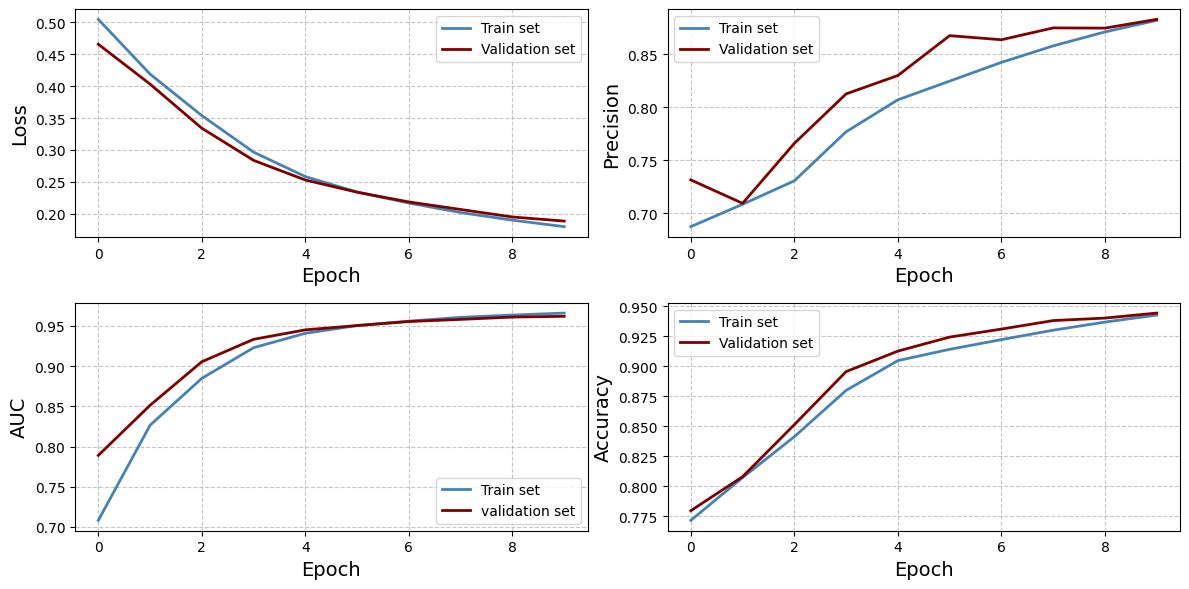

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(model_preformance["loss"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(model_preformance["val_loss"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(model_preformance["precision"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(model_preformance["val_precision"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("Precision", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(model_preformance["auc"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(model_preformance["val_auc"], label= "validation set", color='maroon', linewidth=2)
plt.ylabel("AUC", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(model_preformance["accuracy"], label= "Train set", color='steelblue', linewidth=2)
plt.plot(model_preformance["val_accuracy"], label= "Validation set", color='maroon', linewidth=2)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

In [48]:
y_pred = np.rint(seq_model.predict(X_test))

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [49]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize=None)

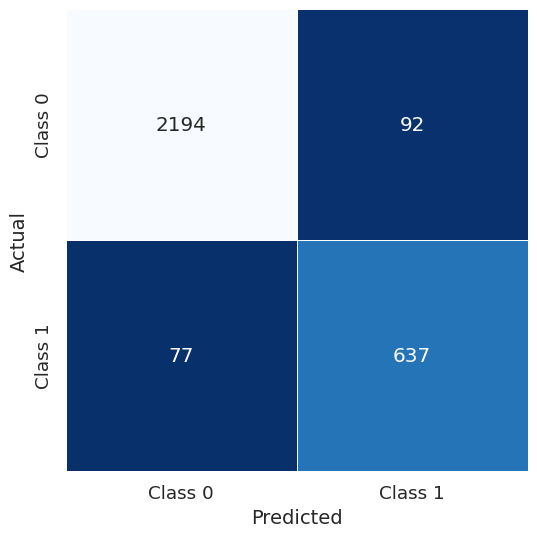

In [50]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='Blues_r', cbar=False, square=True,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

## Functional API

In [51]:
keras.backend.clear_session()
inputs = keras.Input(shape=(X_train.shape[1],), name="input_layer")
features = keras.layers.Dense(10, activation="relu", name="first_layer")(inputs)
features = keras.layers.Dropout(rate=0.2, name="first_drop_out")(features)
features = keras.layers.Dense(20, activation="relu", name="second_layer")(features)
features = keras.layers.Dense(5, activation="relu", name="third_layer")(features)
features = keras.layers.Dropout(rate=0.3, name="second_drop_out")(features)
outputs = keras.layers.Dense(1, activation="sigmoid", name="output_layer")(features)
func_model = keras.Model(inputs=inputs, outputs=outputs, name="func_model")
func_model.summary()

Model: "func_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 18)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_layer (Dense)                  │ (None, 10)                  │             190 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ first_drop_out (Dropout)             │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_layer (Dense)                 │ (None, 20)                  │             220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ third_layer (Dense)                  │ (None, 5)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ second_drop_out (Dropout)            │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521 (2.04 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

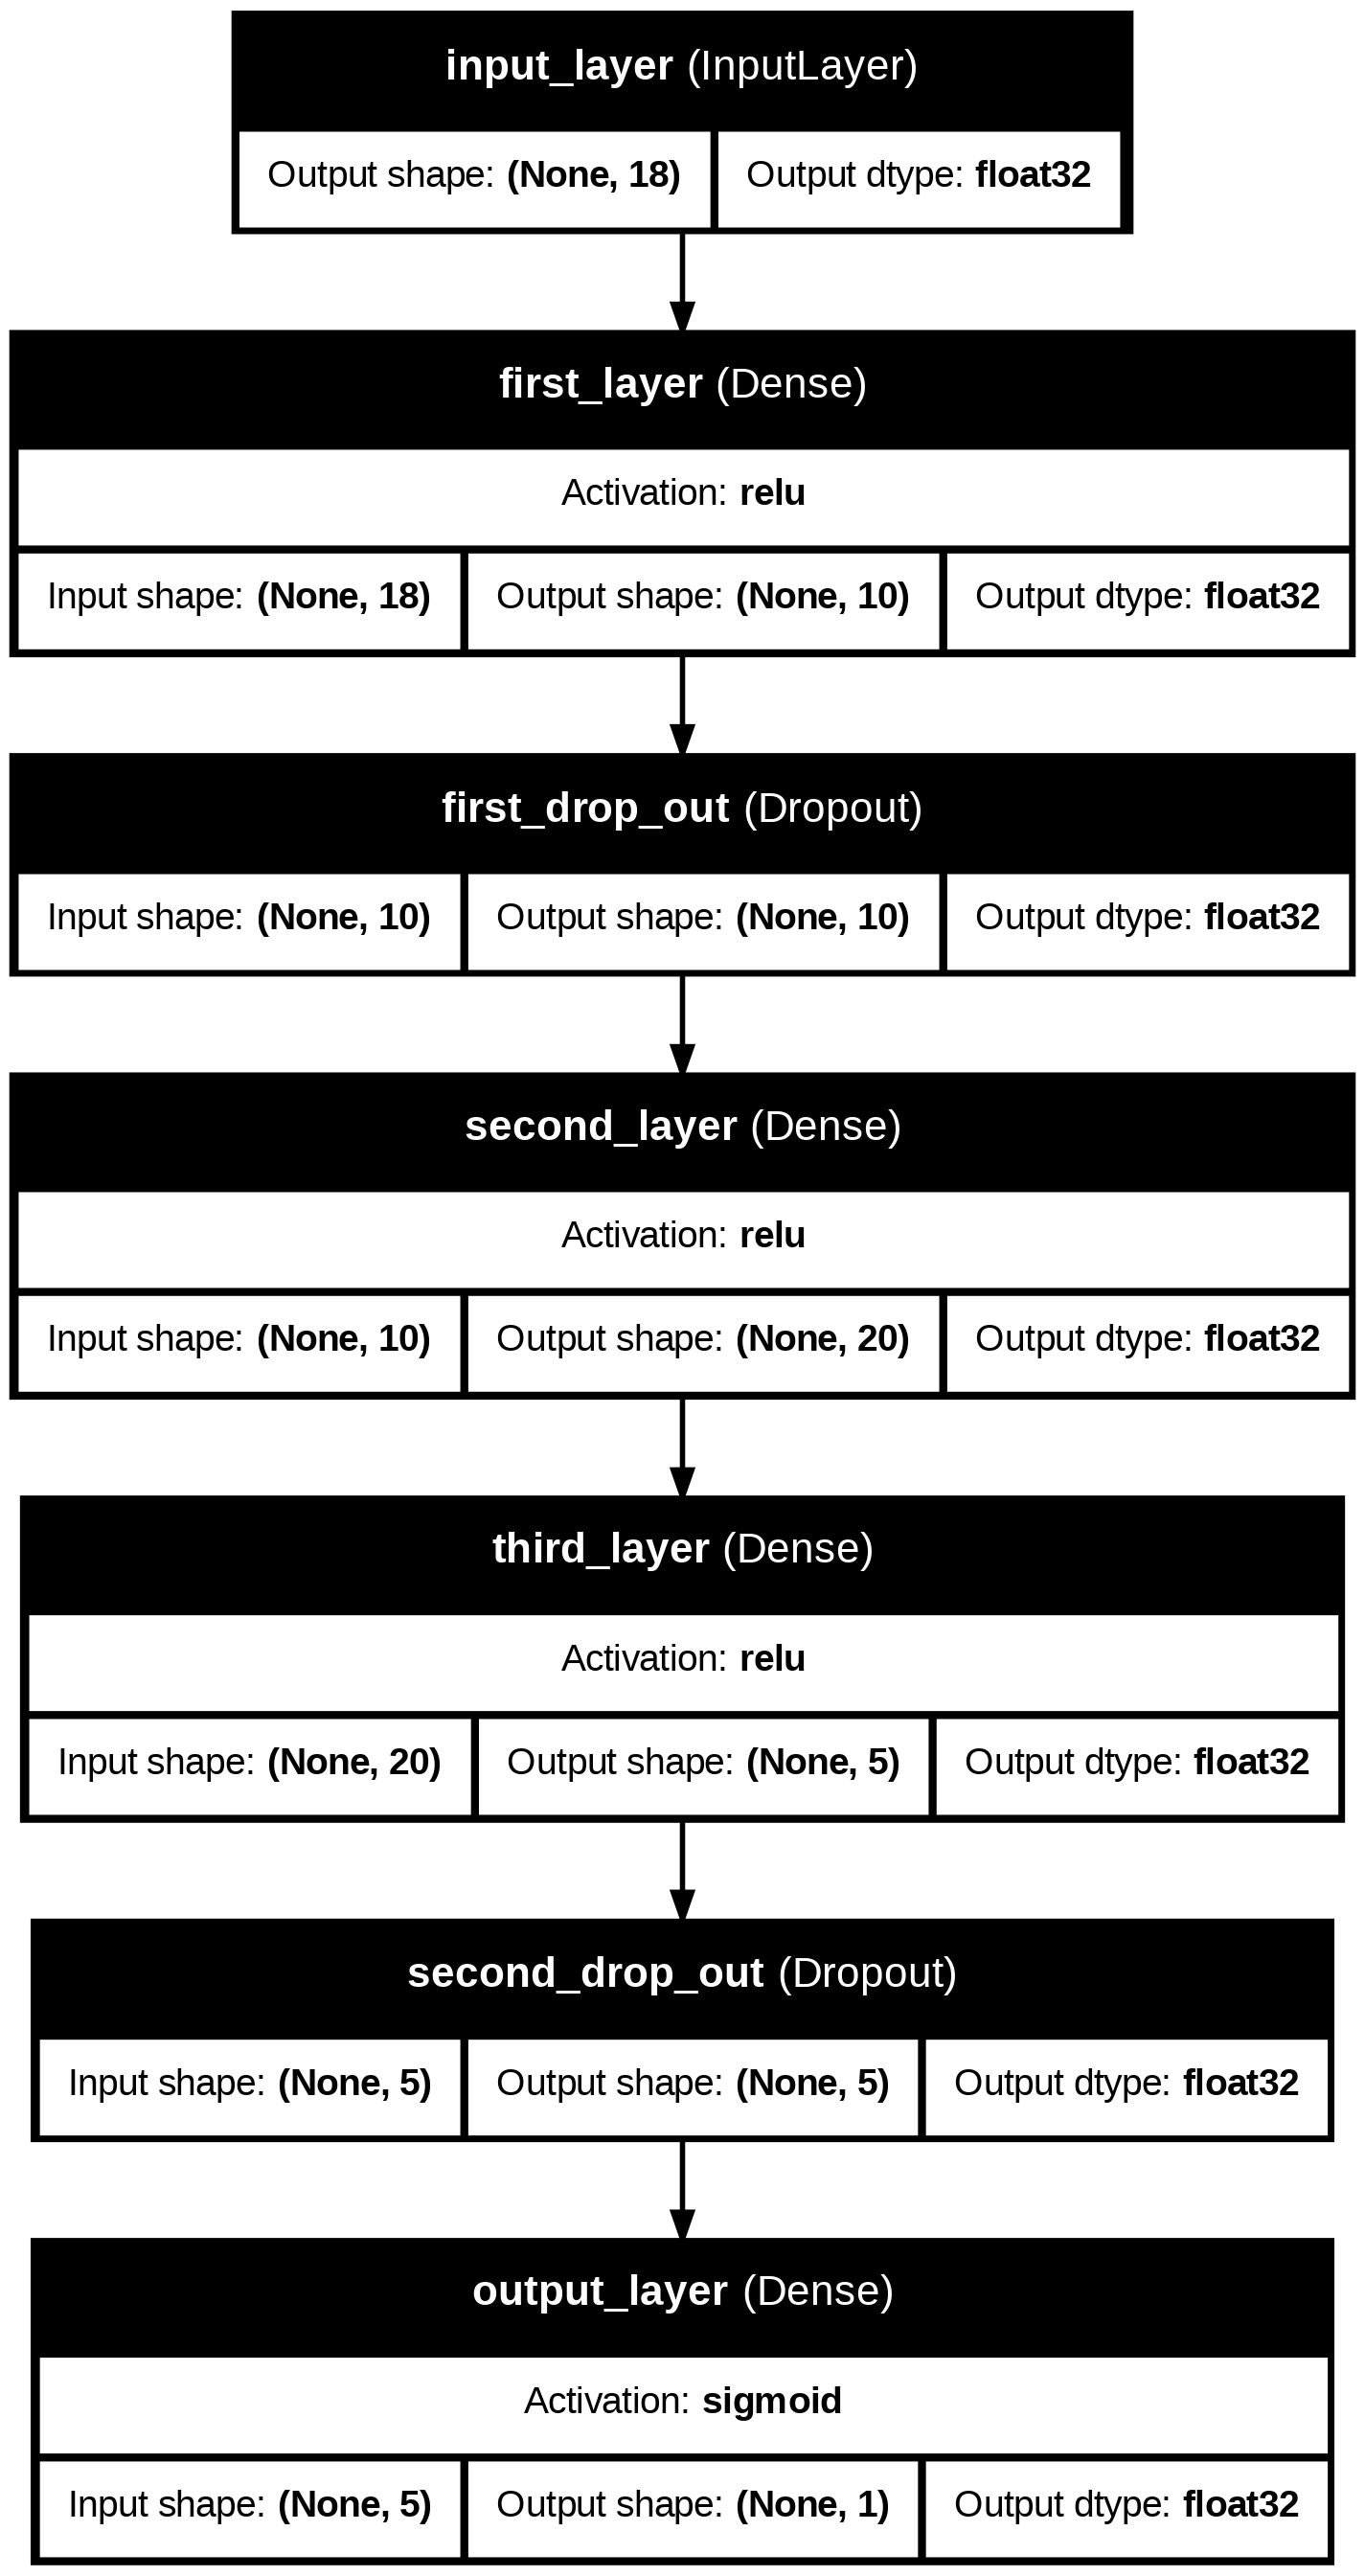

In [52]:
keras.utils.plot_model(func_model, "clf.png", show_dtype=True, show_layer_activations=True,
                       show_layer_names=True, show_shapes=True)

In [53]:
func_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
func_model.fit(X_train,y_train, validation_split=0.3, epochs=10, batch_size=128, callbacks=[early_stopping])

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6078 - loss: 0.6397 - val_accuracy: 0.7525 - val_loss: 0.5210
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7582 - loss: 0.5414 - val_accuracy: 0.7528 - val_loss: 0.4773
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7705 - loss: 0.4983 - val_accuracy: 0.7528 - val_loss: 0.4386
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7797 - loss: 0.4691 - val_accuracy: 0.8072 - val_loss: 0.4009
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8066 - loss: 0.4311 - val_accuracy: 0.8303 - val_loss: 0.3602
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8145 - loss: 0.4154 - val_accuracy: 0.8369 - val_loss: 0.3241
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8455 - loss: 0.3722 - val_accuracy: 0.8814 - val_loss: 0.2974
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8479 - loss: 0.3603 - val_accuracy: 0.9142 - val_loss

In [55]:
func_model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9173 - loss: 0.2421


[0.23052075505256653, 0.9286666512489319]

In [56]:
y_pred = np.rint(func_model.predict(X_test))

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [57]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')
conf_mat

array([[0.95975503, 0.04024497],
       [0.17086835, 0.82913165]])